
<html><center>

# Source code 
## "Mapping seasonal glacier melt across the Hindu Kush Himalaya with time series SAR "
<center><a href="doi.org/10.5194/tc-2020-181">doi.org/10.5194/tc-2020-181</a>


In [ ]:
import ee
from IPython.display import Image

ee.Authenticate()
ee.Initialize()

In [85]:
# --------------Define parameters ---------------- #

# A priori "dry/frozen" period
dryStart = '2019-01-01'
dryEnd = '2019-02-28'

# A priori "melting" period
meltStart = '2019-07-01'
meltEnd = '2019-08-30'

# Define a calendar year for processing
studyStart = '2019-01-01'
studyEnd = '2020-01-01'

# Set the Z score limit
zLim = 2

# Define the band for retrieval (add to a list for ee to understand)
band = ['VH']

# Define a threshold for critical decrease from mean winter backscatter to classify a melt retrieval
threshold = 3 #dB
# -------------------------------------------------------------------
# Import assets
gamdam = ee.FeatureCollection("users/coreyscher/GAMDAM2018")
hkh_outline = ee.FeatureCollection("users/coreyscher/HKHoutline")
s1 = ee.ImageCollection("COPERNICUS/S1_GRD")

# -------------------------------------------------------------------
# Construct a glacier mask

glacierMask = ee.Image().paint(gamdam.filterBounds(hkh_outline), 1)

# -------------------------------------------------------------------------------

# Bring in Radar data -----------------------------------------------------------
# Filter S1 data by orbit direction, instrument mode, and available bands

s1 = s1.filterBounds(hkh_outline).filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))\
    .filter(ee.Filter.eq('instrumentMode', 'IW'))
            
#----Separate S1 by orbit type ---------------------

s1A = s1.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
s1D = s1.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))


# --------------------------------------------------------------------
# Make list of relative orbit numbers unique to each orbit
#

def orbs(image):
    image = ee.Image(image)
    start = image.get('relativeOrbitNumber_start')
    return start

orbitsD = s1D.toList(s1D.size()).map(orbs).distinct()
orbitsA = s1A.toList(s1A.size()).map(orbs).distinct()

# ----------------------------------------------------------------------
# Function to classify melt retrievals

def meltAlg(imColl):
    def byOrbit(orbitNumber):
            
    # Calculate relevant statistics for threshold detection
    # Note: we calculate seasonal statistics assuming that the mean is normally distributed across summer and winter
    # This avoids the computational cost of converting each image to power, tabulating statistics, and converting back to dB
            
        winterMean = imColl.filterDate(dryStart, dryEnd)\
                    .select(band)\
                    .filterMetadata('relativeOrbitNumber_start', 'equals', orbitNumber)\
                    .mean()
            
        summerMean = imColl.filterDate(meltStart, meltEnd)\
                    .select(band)\
                    .filterMetadata('relativeOrbitNumber_start', 'equals', orbitNumber)\
                    .mean()

        winterStd = imColl.filterDate(dryStart, dryEnd)\
                    .select(band).filterMetadata('relativeOrbitNumber_start', 'equals', orbitNumber)\
                    .reduce(ee.Reducer.stdDev())

    # Filter image collection by orbit path row
            
        imCol = imColl.filterDate(studyStart, studyEnd).select(band) \
                .filterMetadata('relativeOrbitNumber_start', 'equals', orbitNumber)
        
    # Calculate a Z score for this row and orbit direction
            
        zScore = winterMean.subtract(summerMean).divide(winterStd)        
    
    # Construct a Z score mask
            
        zMask = zScore.gt(zLim);
        
        def melt(i):
            i = ee.Image(i)
            date = ee.Image(ee.Number(i.date().getRelative('day', 'year')))
            i = i.lt(winterMean.subtract(threshold)).set('system:time_start', i.get('system:time_start'))
            finalIm = (i.addBands(date)\
                          .addBands(zScore)\
                          .rename(['meltObs', 'DOY', 'zScore'])\
                          .toInt())
                       
            # Mask for regions that do not have a z score greater than the threshold (i.e. lacks a significant seasonal melt signal)
            finalIm = finalIm.updateMask(zMask).updateMask(ee.Image(finalIm.select(['meltObs'])).eq(1))
            
            # Update to mask out regions without melt observations
            return finalIm

        # Map the function across all orbit numbers in the collection
        return imCol.map(melt)
        
        # Return the list of image collections processed on each orbit cycle
                       
    return byOrbit


# -------------- Final product generation ------------ #

# Map the melt algorithm across the list of descending orbits
descending = orbitsD.map(meltAlg(s1D))

# Map the melt algorithm across the list of ascending orbits
ascending = orbitsA.map(meltAlg(s1A))

# Combine the datasets into one list
melt_collections = descending.cat(ascending)
                       
# Define a function to combine the image collections by greatest Z score on a per-pixel basis
def mergeCols(imageCol):
    
    # Set the proper class for the list element (image collection)
    imageCol = ee.ImageCollection(imageCol)

    # Make a z score image
    zScore = imageCol.select(['zScore']).mean()

    # Filter the collection into the relevant bands
    meltCol = imageCol.select(['meltObs', 'DOY'])
    # Choose the first melt observation in the time series
    onset = meltCol.select(['DOY']).reduce(ee.Reducer.firstNonNull()).toInt()

    # Choose the last melt observation in the time series                       
    offset = meltCol.select(['DOY']).reduce(ee.Reducer.lastNonNull()).toInt()

    # Count the number of observations
    count = ee.Image(imageCol.select(['meltObs']).map(lambda x: x.unmask()).count())
                       
    # Calculate the melt frequency in the record
    daysMeltObs = meltCol.select(['meltObs']).sum()
    meltFrac = daysMeltObs.divide(count)
    
    classified_im = ee.Image(onset.addBands(offset)\
            .addBands(daysMeltObs)\
            .addBands(zScore).addBands(count))\
            .rename(['meltOn', 'meltOff', 'meltObs', 'zScore', 'count'])\
            
    return classified_im
        
melt = melt_collections.map(mergeCols)

#  Mosaic by the greatest Z score
finalProduct = ee.ImageCollection(melt).qualityMosaic('zScore')

# Generate an image of the annual melt fraction
meltFraction = finalProduct.select(['meltObs'])\
                            .divide(finalProduct.select(['count']))\
                            .multiply(100).rename(['meltFrac']).toInt()

# Generate a final product

# Mask for the z score threshold
# Run a 9x9 median window filter across the results
finalProduct = finalProduct.addBands(meltFraction)\
                .updateMask(finalProduct.select(['zScore']).gt(zLim))\
                .focal_median(9, "square", "pixels")\
                .updateMask(glacierMask.eq(1)).addBands(glacierMask)

In [ ]:
roi = ee.Geometry.Rectangle([[86.54093388511323,27.86604195689137], 
                            [86.9069159407773,28.159442396466485]])

# Create a URL of visualized data around Mount Everest
url = finalProduct.select(['meltOff']).getThumbUrl({
    'min': 250, 'max': 350, 'dimensions': 512, 'region': roi,
    'palette': ["00ffdb","005aff","002387"]})
print("Melt offset (2019)", url)

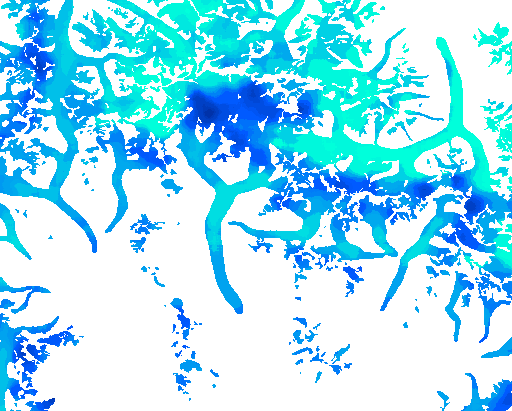

In [92]:
# Display the thumbnail of melt offset over the Mount Everest region in 2019
Image(data='example_results.png')

In [ ]:
# Export final results to GEE assets
Export.image.toAsset({image: finalProduct, 
                      description: '2019_glacMelt_90m',
                      scale: 90, 
                      region: hkh_outline.geometry().bounds().buffer(1000),
});
